# Simple Regression Example 
Attempting to fit house prices, using the [House prices dataset (Kaggle)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) <br> 
Based on a [tutorial](https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea) by Mauro Di Pietro

### 0. Imports

In [1]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

import warnings
warnings.filterwarnings("ignore")


### 1. The House Prices Dataset

Loading the CSV dataset

In [2]:
dtf = pd.read_csv("./data/data_houses.csv",index_col='Id')

In [3]:
cols = ["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","FullBath","YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass", "SalePrice"]
dtf = dtf[cols]

In [4]:
dtf.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
Id,,,,,,,,,,,
1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


Examining the target feature - "SalePrice"

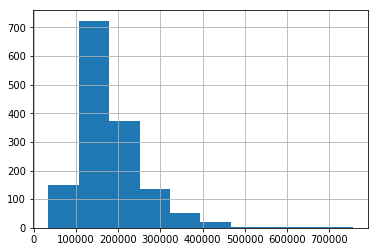

In [5]:
dtf.SalePrice.hist()

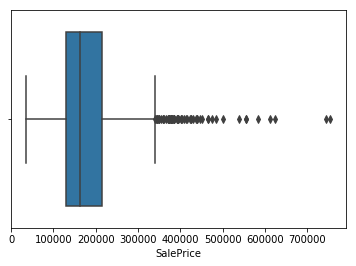

In [6]:
sns.boxplot(dtf.SalePrice)

Viewing Correlations to the target feature:

In [7]:
dtf_corr = dtf.corr(method="pearson").loc[["SalePrice"]]

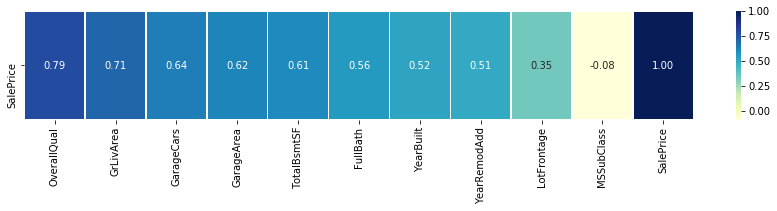

In [9]:
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)


Let's examine some of the correlations:

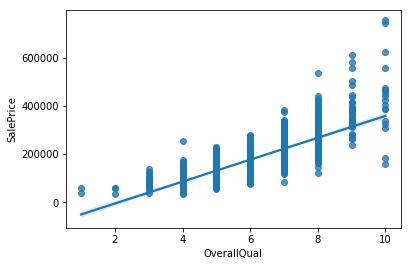

In [10]:
sns.regplot(data=dtf,x='OverallQual',y='SalePrice')

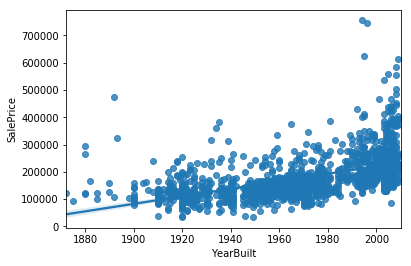

In [11]:
sns.regplot(data=dtf,x='YearBuilt',y='SalePrice')

While the plot above is difficult, we can bin the year column then group by and view the mean price

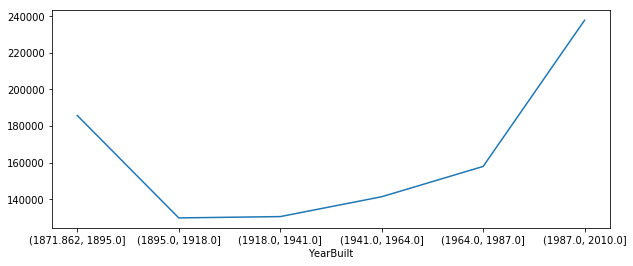

In [23]:
fig, ax = plt.subplots(figsize=(10,4))
dtf.groupby(pd.cut(dtf['YearBuilt'],6))['SalePrice'].mean().plot(kind='line',ax=ax)

### 2 - Preprocessing

A. Split to Train and Test, then see the target feature distributions:

In [ ]:
from sklearn.model_selection import train_test_split

In [33]:
dtf_train, dtf_test = train_test_split(dtf, 
                      test_size=0.25)

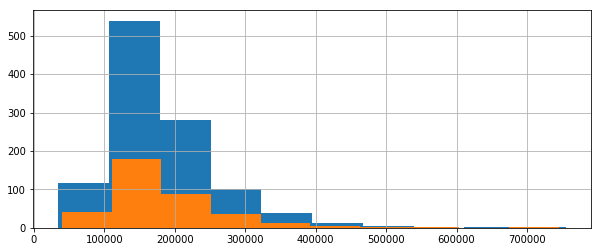

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
dtf_train.SalePrice.hist(ax=ax)
dtf_test.SalePrice.hist(ax=ax)

B. Fill Null values:

In [35]:
dtf_train.isna().sum()

OverallQual       0
GrLivArea         0
GarageCars        0
GarageArea        0
TotalBsmtSF       0
FullBath          0
YearBuilt         0
YearRemodAdd      0
LotFrontage     191
MSSubClass        0
SalePrice         0
dtype: int64

In [36]:
dtf_train["LotFrontage"] = dtf_train["LotFrontage"].fillna(dtf_train["LotFrontage"].mean())
dtf_test["LotFrontage"] = dtf_test["LotFrontage"].fillna(dtf_train["LotFrontage"].mean())


C. One hot encoding for categorical variables

In [45]:
vc = dtf_train.MSSubClass.value_counts()

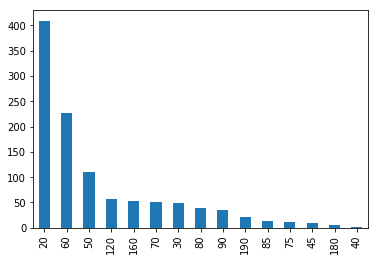

In [46]:
vc.plot(kind='bar')

In [49]:
low_categories = vc[vc <50]

In [56]:
new_col_train = dtf_train.MSSubClass.apply(lambda x: 5000 if x in low_categories else x )
new_col_test = dtf_test.MSSubClass.apply(lambda x: 5000 if x in low_categories else x )

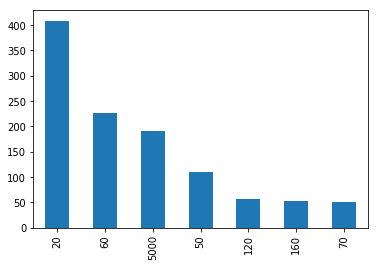

In [57]:
new_col_train.value_counts().plot(kind='bar')

In [58]:
dummy_train = pd.get_dummies(new_col_train, prefix="MSSubClass")
dummy_test = pd.get_dummies(new_col_test, prefix="MSSubClass")


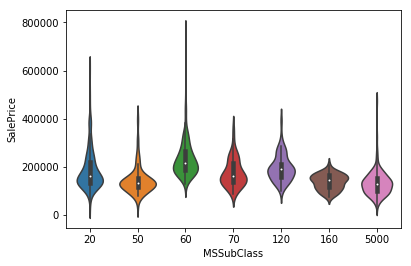

In [66]:
sns.violinplot(x=new_col_train,y=dtf_train.SalePrice)

Make sure that all dummies exist both in the train and test so we do not get a feature mismatch in our model

In [101]:
dummy_train.shape,dummy_test.shape

((1095, 7), (365, 7))

Concat the one-hot attributes and drop the original

In [67]:
dtf_train = pd.concat([dtf_train, dummy_train], axis=1)
dtf_test = pd.concat([dtf_test, dummy_test], axis=1)

In [ ]:
dtf_train = dtf_train.drop("MSSubClass", axis=1)
dtf_test = dtf_test.drop("MSSubClass", axis=1)


### 3. Create a Baseline Model

Separate X from Y

In [79]:
X_train = dtf_train.drop('SalePrice',axis=1)
X_test = dtf_test.drop('SalePrice',axis=1)

y_train = dtf_train['SalePrice']
y_test = dtf_test['SalePrice']




Train a linear regression model

In [74]:
from sklearn.linear_model import LinearRegression

In [75]:
model = LinearRegression()

In [82]:
prediction = model.fit(X_train,y_train).predict(X_test)

Evaluation using R2: R Squared is the squared sum of differences from the actual values and the predicted values, divided by the squared differences from the mean (i.e var*n)


In [88]:
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

In [89]:
r2_score(y_test,prediction)

0.7613369744766412

<br> What is a good R2 score? This is a "dangerous" question, a better question is what does the score "means"
<br>
High R2 means that the model "explains" a lot of the variance, i.e. that the behaviour is "predicted".
It *doesn't* mean that the model is always right!
<br>
Let's see more metrics:

In [99]:
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,prediction)))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, prediction)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, prediction))))

## residuals
residuals = y_test - prediction
max_error = max(prediction) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], prediction[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.147
Mean Absolute Error (Σ|y-pred|/n): 25,425
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 41,439
Max Error: -312,908


We now plot the true values against the predicted values. 
<br> In the regression line, the predicted values are always on the function y=x

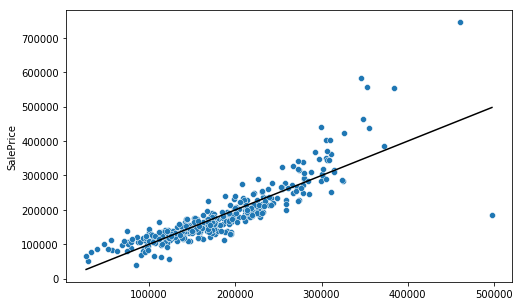

In [110]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(prediction,y_test,ax=ax)
sns.lineplot(prediction,prediction,ax=ax,color='black')

We can already learn that our bigger mistakes are when the sale price is larger.
<br>
Lets take a deeper looks into the 'residuals'

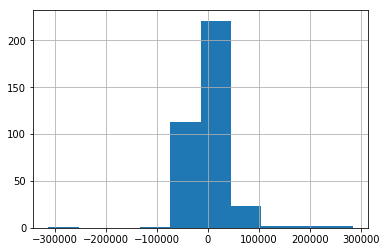

In [112]:
residuals.hist()

Text(0.5, 1.0, 'Residuals (%)')

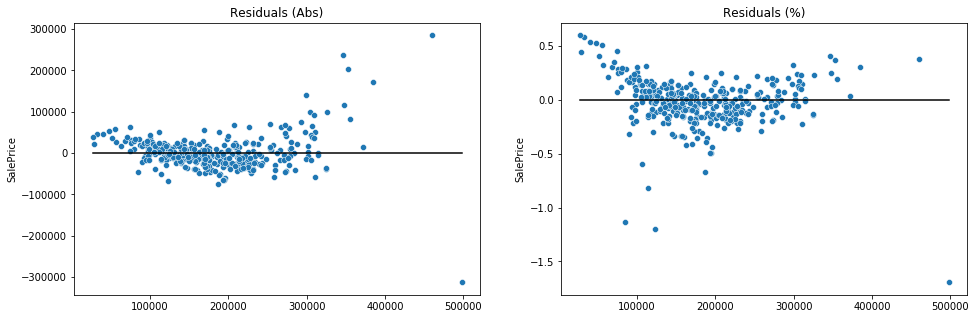

In [129]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.scatterplot(prediction,residuals,ax=ax[0])
sns.lineplot(prediction,0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)")
sns.scatterplot(prediction,residuals/y_test,ax=ax[1])
sns.lineplot(prediction,0,ax=ax[1],color='black')
ax[1].set_title("Residuals (%)")

So we can see that we have "small" mistakes and "big" mistakes. Let's look into that:

In [130]:
rel_res=residuals/y_test
rel_res=rel_res.abs()

We were quite good (error less than 5%) for 25% of the test data:

In [137]:
len(rel_res[rel_res<0.05])/len(rel_res)

0.2547945205479452

However, we had bigger mistakes for about 21% of the test data:

In [139]:
len(rel_res[rel_res>0.2])/len(rel_res)

0.21643835616438356

### 4. Model Explainability Using SHAP

We are first interested in feature importance.
<br>
In the simple linear regression model, we can look at the learned coefficients:

In [149]:
print("Model coefficients:\n")
for i in range(len(X_train.columns)):
    print(X_train.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

OverallQual = 20586.0709
GrLivArea = 62.155
GarageCars = 11741.5742
GarageArea = 7.4286
TotalBsmtSF = 15.5036
FullBath = -7705.1308
YearBuilt = 378.4061
YearRemodAdd = 260.5267
LotFrontage = -184.1707
MSSubClass_20 = 17390.0647
MSSubClass_50 = 8759.2118
MSSubClass_60 = 53.4118
MSSubClass_70 = 4672.9196
MSSubClass_120 = -6401.9222
MSSubClass_160 = -31189.3327
MSSubClass_5000 = 6715.647


However, since our features are not normalized, it is hard to assess which ones are the most important.
<br>
For that, we use SHAP

In [153]:
import shap

In [160]:
shap_sample = X_train.sample(500)

In [161]:
explainer = shap.Explainer(model.predict, shap_sample)
shap_values = explainer(shap_sample)

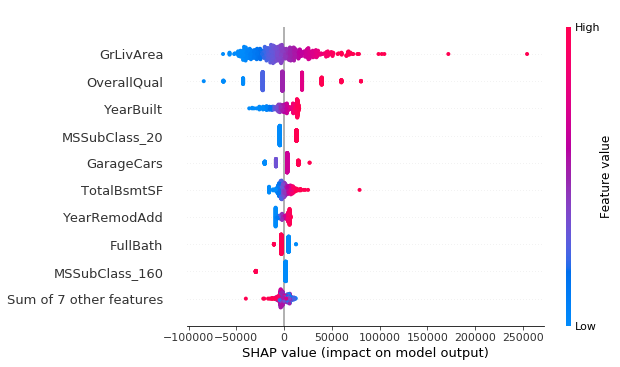

In [162]:
shap.plots.beeswarm(shap_values)

Remember that we can also do that to explain the prediction of a single element:

In [171]:
test_shap_values = explainer(X_test)

In [197]:
rel_res[rel_res==rel_res.max()]

Id
524    1.693685
Name: SalePrice, dtype: float64

In [198]:
prediction[236]

497658.33282897086

In [190]:
X_test[rel_res==rel_res.max()]


,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass_20,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_120,MSSubClass_160,MSSubClass_5000
Id,,,,,,,,,,,,,,,,
524,10,4676,3,884,3138,3,2007,2008,130.0,0,0,1,0,0,0,0


In [193]:
X_test.index.get_loc(524)

236

In [202]:
y_test.loc[524],prediction[236]

(184750, 497658.33282897086)

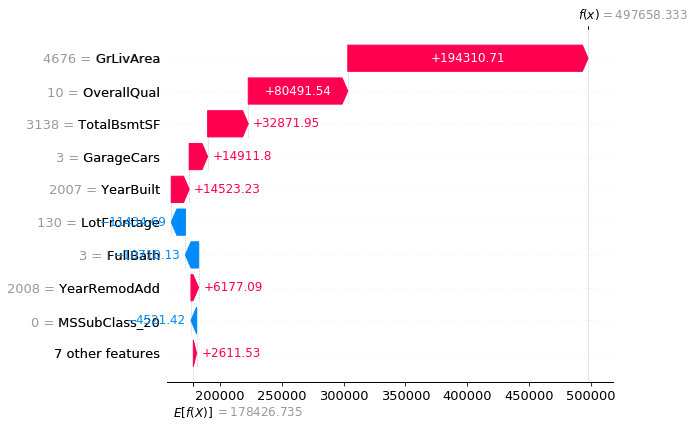

In [203]:
shap.plots.waterfall(test_shap_values[236])

We can see that the model overestimated mainly due to the GrLivArea.
<br>
We can now check this for all samples in our test - Why did we over estimate?

In [219]:
len(residuals[residuals>50000])

26

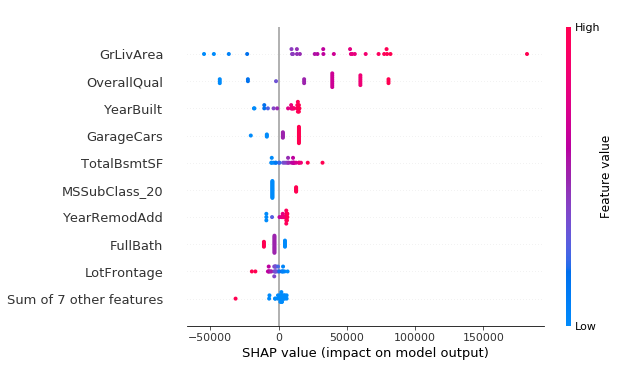

In [221]:
bad_examples = X_test.loc[residuals[residuals>50000].index]
bad_examples_shap_values = explainer(bad_examples)
shap.plots.beeswarm(bad_examples_shap_values)

To get even a deeper understanding regarding our model's mistake, we can compare the distributions of our mistakes to good predictions

In [224]:
over_estimates = X_test.loc[residuals[residuals>50000].index]

In [226]:
good_estimates = X_test.loc[rel_res[rel_res<0.05].index]

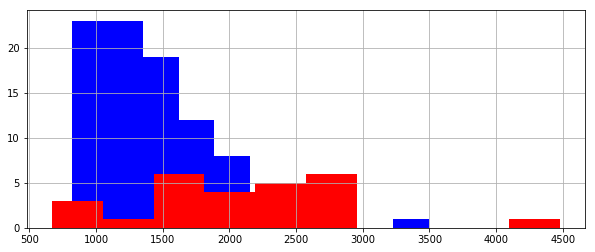

In [236]:
fig, ax = plt.subplots(figsize=(10,4))
good_estimates.GrLivArea.hist(ax=ax,color='blue')
over_estimates.GrLivArea.hist(ax=ax,color='red')

We can see that our overestimas contains "larger" apartments.
<br> While the model correctly understood that larger apartments are often more expensive, this is not always correct! 